# SmartMeter Log Analysis

This notebool analyzes the SmartMeter camera system logfile for events and compute statistics of repeated activity phases. The logfile contains events of the following activities named after their scripts:

* *fileservice.sh*: picture upload and file management
* *logrotate.sh*: logfile upload and file management
* *smeter.sh*: all activities

The *smeter.sh* activity contains all other.

**Download and prepare logfiles**

The path to `filterlog.sh` script is different on the local dev system and on mybinder.org. We look in different root paths for `filterlog.sh` and once found it get executed.

In [1]:
root_paths <- c('/SmartMeter', '..')
filterlog.sh <- 'src/filterlog.sh'
filterlog.sh <- paste0(root_paths, '/', filterlog.sh)
filterlog.sh <- file.access(filterlog.sh, mode=4)
filterlog.sh <- head(filterlog.sh[filterlog.sh == 0], n=1)
filterlog.sh <- names(filterlog.sh)
# run filterlog.sh
system(paste('sh', filterlog.sh, '> smartmeter.log'), intern=TRUE)

character(0)

In [2]:
# input
logfile_name <- 'smartmeter.log'

**Import relevant libraries**

In [3]:
library(tidyverse)
library(lubridate)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




### Load logfile

Load and parse csv with `;` as delimiter.

In [4]:
logfile <- read_delim(file=logfile_name, col_names=FALSE, delim=';')
colnames(logfile) <- c('date', 'time', 'script', 'status', 'message')
head(logfile)

Parsed with column specification:
cols(
  X1 = col_date(format = ""),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_character(),
  X5 = col_character()
)



date,time,script,status,message
<date>,<chr>,<chr>,<chr>,<chr>
2020-08-29,"01:02:01,1598655721",/home/pi/smartmeter/smeter.sh,INFO,SmartMeter camera system starts.
2020-08-29,"01:02:01,1598655721",/home/pi/smartmeter/maintenance.sh,INFO,Maintenance mode is: off
2020-08-29,"01:02:07,1598655727",/home/pi/smartmeter/takepicture.sh,INFO,Picture successfully taken: /home/pi/smartmeter/images/20200829_010201.png
2020-08-29,"01:02:09,1598655729",/home/pi/smartmeter/fileservice.sh,INFO,Website dropbox.com is reachable.
2020-08-29,"01:02:09,1598655729",/home/pi/smartmeter/fileservice.sh,INFO,Upload to Dropbox: 20200829_010201.png
2020-08-29,"01:02:47,1598655767",/home/pi/smartmeter/fileservice.sh,INFO,Delete file: /home/pi/smartmeter/images/20200829_010201.png


### Prepare data

Filter and convert data types. Convert date and time to timestamp (using lubridate package)

In [5]:
# convert timestamp
logfile <- logfile %>% 
    mutate(time_sec = str_extract(time, '\\d\\d:\\d\\d:\\d\\d') ) %>%
    mutate(timestamp = ymd_hms(paste(date, time_sec))) %>% 
    select(timestamp, script, status, message)

### Simple stats and plots

Some simple stats figures supported with plots to obtain an overview on all events within a logfile. The statistics are

* event count per status
* file completeness
* timeseries of events
* status per hour

#### Event Count per status

In [6]:
# event count per status in logfile
# status: INFO, WARN, ERROR
logfile %>% 
    group_by(status) %>%
    summarise(evt_count=n())

status,evt_count
<chr>,<int>
ERROR,1
INFO,3176
WARN,3


#### File completness

We expect 3 file uploads per hour. We only output date and time when there are more or less than 3 files per hour. In the regular case, we expect an empty list.

In [7]:
# add datehour for each entry
logdatehour <- logfile %>% 
    mutate(datehour=ymd_h(paste(date(timestamp), hour(timestamp))))

In [8]:
# File completness
# show list only, if there more or less than 3 files per hour
logdatehour %>%
    filter(str_detect(message, 'Upload to Dropbox')) %>%
    filter(str_detect(message, '.png')) %>%
    group_by(datehour) %>%
    summarise(filecount=n()) %>%
    filter(filecount != 3) 
# expect empty list as result

datehour,filecount
<dttm>,<int>


#### Timeseries of events

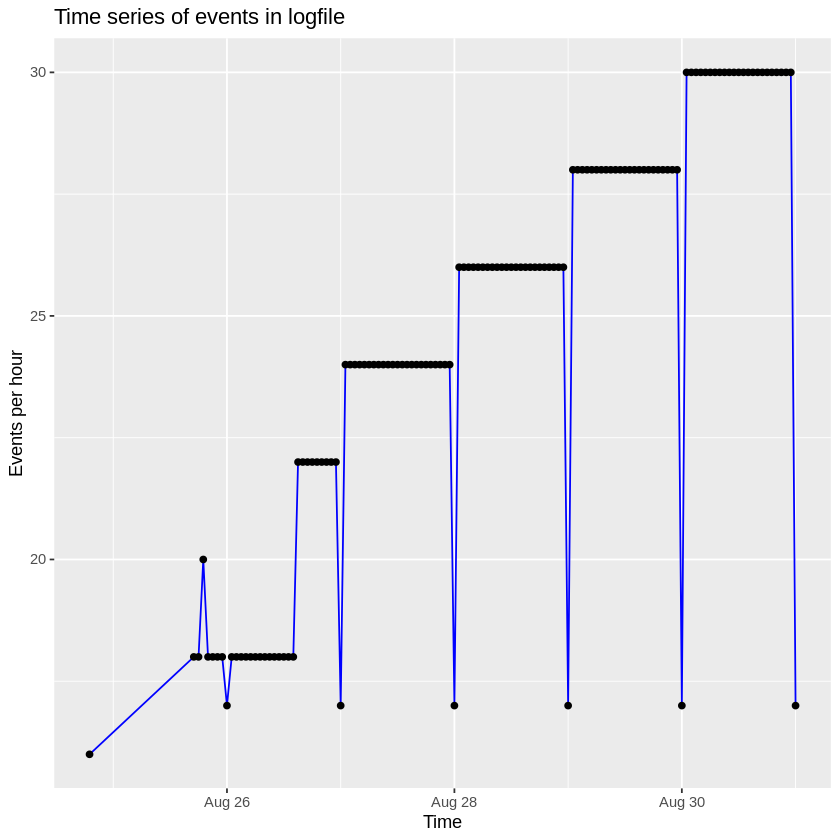

In [9]:
# all events per hour
ggplot( logdatehour %>%
    group_by(datehour) %>%
    summarise(evt_hour=n()),
    aes(x=datehour, y=evt_hour)) +
    geom_line(color='blue') +
    geom_point() +
    xlab('Time') +
    ylab('Events per hour') +
    ggtitle('Time series of events in logfile')

#### Timeseries of events for each status

Possible status names are
* INFO
* WARN
* ERROR

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



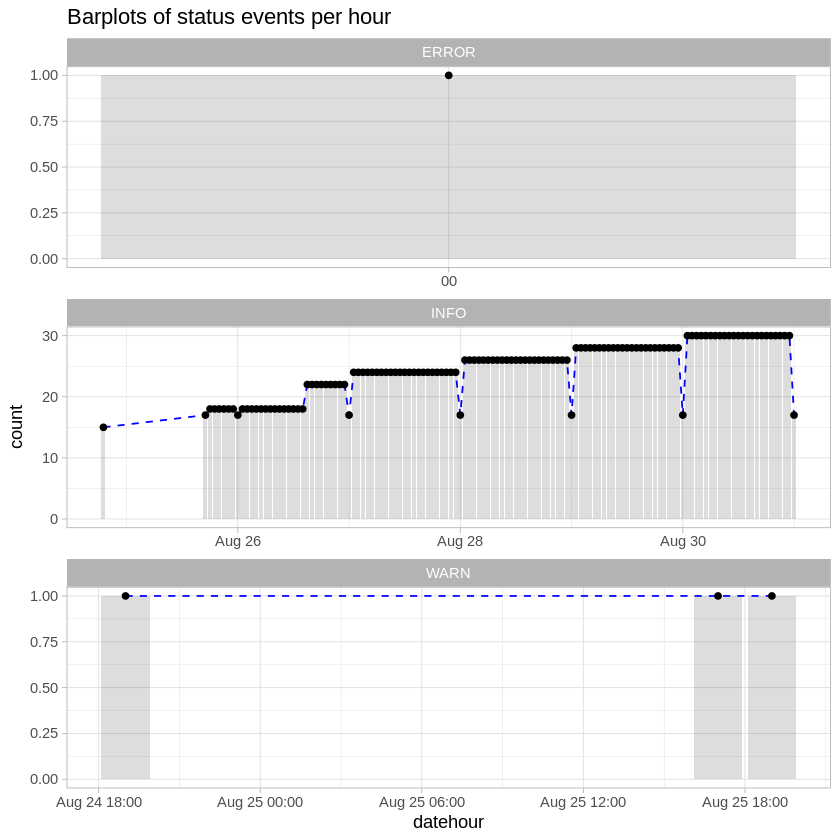

In [10]:
# plot bar chart of each status event counts per hour
ggplot(logdatehour, aes(x=datehour)) +
    geom_bar(alpha=0.2, ) +
    geom_line(stat='count', linetype='dashed', color='blue') +
    geom_point(stat='count') +
    facet_wrap( ~status, scales="free", ncol=1) +
    ggtitle('Barplots of status events per hour') +
    theme_light()

### Activity Duration 

The logfile contains events of the following activities named after their scripts:

* *fileservice.sh*: picture upload and file management
* *logrotate.sh*: logfile upload and file management
* *smeter.sh*: all activities

In this section we filter messages (by msg_str) in log entries (given by script_str) and compute the duration. See function `calc_act_length`.

In [11]:
# computes the length for selected messages of a script name 
calc_act_length <- function(data, script_str, msg_str) {
    evt_logfile <- data %>%
        filter(str_detect(script, script_str)) %>% # script == script_str?
        filter(str_detect(message, msg_str)) %>% # message == msg_str?
        mutate(act_type = script_str) %>% # set evt_type := script_str 
        arrange(timestamp) # sort asc

    # calc event length
    prev_timestamp <- evt_logfile %>% first %>% lag
    evt_logfile <- tibble(prev_timestamp, evt_logfile) %>% # re-compile logfile for event
        mutate(time_interval = interval(prev_timestamp, timestamp)) %>%
        mutate(interval_sec=int_length(time_interval)) # calc event len in seconds
    
    return(evt_logfile)
}

Now, filter the logfile and extract the begin/end events for activties and compute their respective durations in seconds.

In [12]:
# smeter.sh 
smeter <- logfile %>% 
    calc_act_length('smeter.sh', 'SmartMeter camera system') %>%
    filter(str_detect(message, 'SmartMeter camera system shuts down'))
# fileservice.sh
fileservice <- logfile %>%
    calc_act_length('fileservice.sh', 'Upload to Dropbox|Delete file') %>%
    filter(str_detect(message, 'Delete file:'))
# logrotate.sh
# this activity happens once per hour (-> sum all events)
logrotate <- logfile %>%
    calc_act_length('logrotate.sh', 'Upload to Dropbox') %>%
    filter(interval_sec < 1000) %>% # hack: filters out the inteval between two cycles
    group_by(act_type, date(timestamp), hour(timestamp)) %>% 
    summarise(interval_sec=sum(interval_sec)) # sum logrotate activity per hour (=cycle)

### Activity duration stats and plots

We compute summary stats for each activity duration and plot them as a boxplot.

In [13]:
# combine activities
act_duration <- bind_rows(smeter, fileservice, logrotate)

Warning message in bind_rows_(x, .id):
“Vectorizing 'Interval' elements may not preserve their attributes”
Warning message in bind_rows_(x, .id):
“Vectorizing 'Interval' elements may not preserve their attributes”


In [14]:
# descriptive summary stats
act_duration %>% 
    spread(act_type, interval_sec) %>% # convert from long to wide format
    select(smeter.sh, fileservice.sh, logrotate.sh) %>%
    summary

   smeter.sh    fileservice.sh    logrotate.sh   
 Min.   : 158   Min.   : 29.00   Min.   : 5.000  
 1st Qu.:1729   1st Qu.: 34.00   1st Qu.: 6.000  
 Median :1735   Median : 37.50   Median : 9.000  
 Mean   :1723   Mean   : 40.91   Mean   : 9.347  
 3rd Qu.:1743   3rd Qu.: 42.00   3rd Qu.:12.000  
 Max.   :1809   Max.   :528.00   Max.   :19.000  
 NA's   :488    NA's   :225      NA's   :510     

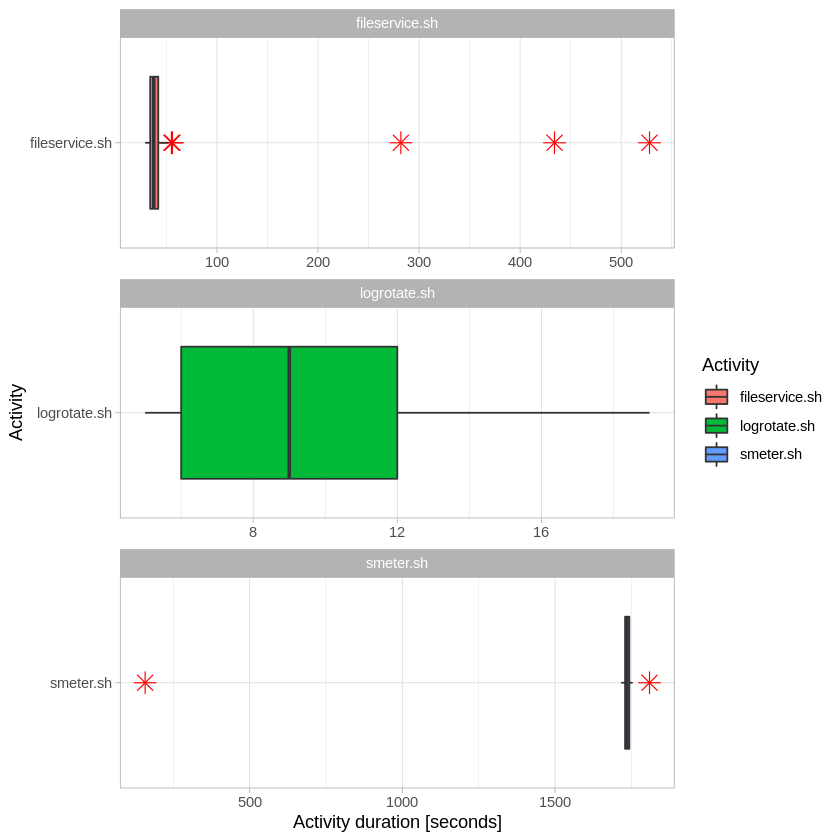

In [15]:
# cleanup ...
act_duration <- act_duration %>%
    select(act_type, interval_sec) %>% 
    drop_na
# ... and plot
p <- ggplot(act_duration, aes(x=act_type, y=interval_sec, fill=act_type)) +
    geom_boxplot(outlier.colour="red", outlier.shape=8, outlier.size=4) +
    facet_wrap( ~act_type, scales="free", ncol=1) +
    coord_flip() +
    xlab("Activity") +
    ylab("Activity duration [seconds]") +
    guides(fill=guide_legend(title="Activity")) +
    theme_light()
p

In [16]:
# store plot as png file
png(file='activity_durations.png', width=600)
p
dev.off()

png 
  2